# Conteúdo
1. Introdução
2. Processo Gerador de Dados
3. Regressão Linear
4. Aprendizado De Máquina
5. Double/Debiased Machine Learning
6. Referências

# Introdução
Digamos que você trabalhe numa empresa de cobranças e construiu um modelo de Aprendizado de Máquina mega deep poderoso que prevê quase perfeitamente que vai pagar ou não a dívida - no set de teste, claro. Ou que você trabalha numa empresa de logística e consegue prever todos os atrasos que irão acontecer. Você então vai todo contente mostrar seu sucesso pro seu chefe ou para a gerência. E, quem diria!, descobre que eles não estão muito interessado em prever essas coisas. Se você pensar bem até que faz sentido. A gerência está muito mais interessada em descobrir como aumentar o pagamento das dívidas ou como diminuir os atrasos. Nessa caso, previsão pode até ser interesse, mas não é o objetivo principal.

O problema de estimação de impacto está dentro de toda uma literatura sobre Inferência Causal. Há anos que cientistas, principalmente da econometria e bioestatística, estudam inferência causal, mas só recentemente o campo vem ganhando relevância na comunidade de aprendizado de máquina.

Hoje, a maioria dos modelos “de prateleira” de aprendizado de máquina não são pensados para otimizar estimação de impacto ou inferência causal. Assim, quem quer responder perguntas de impacto (“como X impacta y”) ou contrafactuais (“como y seria se X fosse diferente do que é”) precisa ainda implementar modelos de inferência causa na mão.

Aqui, vamos ver uma das técnicas que misturam modelos complexos de aprendizado de máquina com fundamentos teóricos de inferência causal. Como exemplo, vamos tentar descobrir como a dosagem de um medicamento impacta no tempo de recuperação de pacientes doentes.

# Processo Gerador de Dados
Imagine que você foi contratado para descobrir o impacto da dosagem de um remédio no tempo de recuperação de pacientes doentes. Parece um problema fácil. Bastaria ver se pessoa que receberam uma alta dosagem recuperam mais ou menos rápido do que pacientes que receberam uma dosagem menos. Seria fácil… Mas os médicos tendem a dar uma dosagem maior para pacientes em estados mais críticos. Por isso, se a gente simplesmente olhar correlações simples iremos obter algo bem contra intuitivo: mais remédio significa mais tempo no hospital.

In [3]:
def make_confounded_data(N):

    def get_severity(df):
        return ((np.random.beta(1, 3, size=df.shape[0]) * (df["age"] < 30)) +
                (np.random.beta(3, 1.5, size=df.shape[0]) * (df["age"] >= 30)))

    def get_treatment(df):
        return (.33 * df["sex"] +
                1.5 * df["severity"] +  df["severity"] ** 2 +
                0.15 * np.random.normal(size=df.shape[0]))

    def get_recovery(df):
        return (2 +
                0.5 * df["sex"] +
                0.03 * df["age"] + 0.03 * ((df["age"] * 0.1) ** 2) +
                df["severity"] + np.log(df["severity"]) +
                df["sex"] * df["severity"] -
                df["medication"])

    np.random.seed(1111)
    sexes = np.random.randint(0, 2, size=N)
    ages = np.random.gamma(8, scale=4, size=N)
    meds = np.random.beta(1, 1, size=N)

    # dados com designação aleatória
    df_rnd = pd.DataFrame(dict(sex=sexes, age=ages, medication=meds))
    df_rnd['severity'] = get_severity(df_rnd)
    df_rnd['recovery'] = get_recovery(df_rnd)

    features = ['sex', 'age', 'severity', 'medication', 'recovery']
    df_rnd = df_rnd[features]  # to enforce column order

    # dados observacionais
    df_obs = df_rnd.copy()
    df_obs['medication'] = get_treatment(df_obs)
    df_obs['recovery'] = get_recovery(df_obs)

    # dados contrafactuais data
    df_ctf = df_obs.copy()
    df_ctf['medication'] = ((df_ctf['medication'] == 1) ^ 1).astype(float)
    df_ctf['recovery'] = get_recovery(df_ctf)

    return df_rnd, df_obs, df_ctf

In [4]:
df_rnd, df_obs, df_ctf = make_confounded_data(10000)
_, test_obs, _ = make_confounded_data(10000)

In [5]:
df_obs.head()

,sex,age,severity,medication,recovery
0,0,35.857725,0.803739,1.842994,2.203728
1,1,26.162705,0.146388,0.621524,1.239984
2,1,25.284784,0.141124,0.942649,0.831819
3,1,41.616736,0.402925,1.258135,2.906798
4,0,22.062427,0.139728,0.153666,0.825900


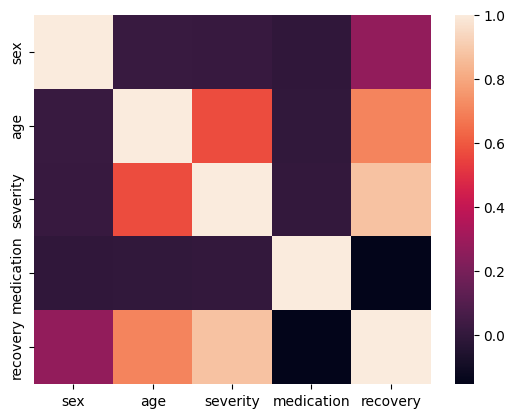

In [6]:
sns.heatmap(df_rnd.corr())
plt.show()

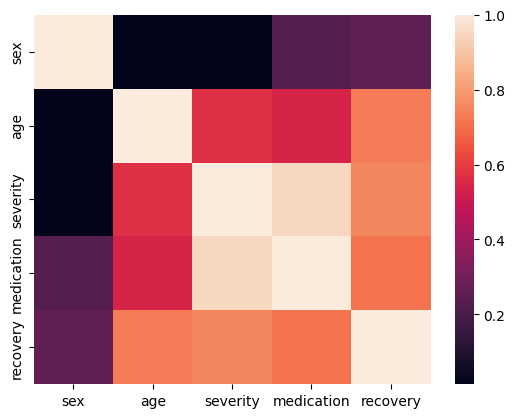

In [7]:
sns.heatmap(df_obs.corr())
plt.show()

Para o propósito desse tutorial, é melhor usar dados simulados para os quais sabemos exatamente o efeito causal. A ideia será ver como nosso modelo consegue identificar esse efeito. Os dados são simulados de forma a gerar estruturas de confusão, em que uma variável causa tanto o tratamento como a variável resposta. No caso, temos que tanto Sexo do paciente quanto Severidade da doença causam tanto a recuperação quanto o tratamento. Vamos também colocar algumas relações não lineares que são pouco triviais.

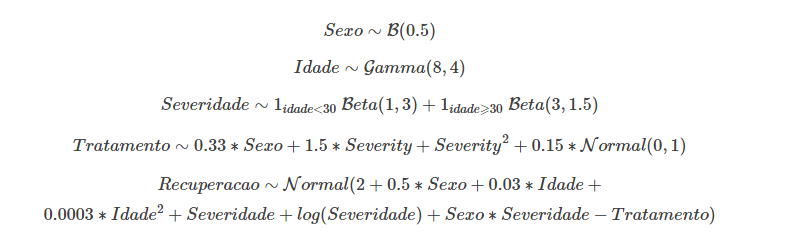

O que é importante perceber no processo acima é que o efeito causal do medicamento é -1, isto é, **aumentar a dose do medicamento 1mg diminui o tempo no hospital em um dia.**

# Regressão Linear
Se você tem contato com a área de econometria ou estatística seu pais devem ter te falado que sempre que você quer controlar para algum fator em dados observacionais você precisa rodar uma regressão linear. Essa é uma boa intuição. Regressão linear tem uma interpretação de controlar para os fatores incluídos no modelo que simula dados experimentais. Assim, é de se esperar que se a gente controlar as variáveis de confusão, Sexo e Severidade, deveríamos ser capazes de achar o efeito causal do medicamento. Em outras palavras, regressão linear nos daria o efeito do medicamento mantidos Sexo e Severidade constante. Certo? Vamos ver…

In [2]:
import pandas as pd
import numpy as np
from toolz.curried import *
import patsy
from itertools import product
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from toolz.curried import *

In [8]:
import statsmodels.formula.api as smf

In [10]:
formula = "recovery ~ sex + age + severity + medication"
formula

'recovery ~ sex + age + severity + medication'

In [11]:
model = smf.ols(formula, data=df_obs).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               recovery   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                 1.211e+04
Date:                Mon, 10 Apr 2023   Prob (F-statistic):               0.00
Time:                        14:25:28   Log-Likelihood:                -7986.4
No. Observations:               10000   AIC:                         1.598e+04
Df Residuals:                    9995   BIC:                         1.602e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3349      0.018    -75.306      0.000      -1.370      -1.300
sex            1.2991      0.015     85.216      0.000       1.269       1.329
age            0.0514      0.001     87.000      0.000       0.050       0.053
severity       7.2146      0.083     86.812      0.000       7.052       7.377
medication    -2.0233      0.032    -62.274      0.000      -2.087      -1.960
==============================================================================
Omnibus:                     7256.477   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183513.117
Skew:                          -3.212   Prob(JB):                         0.00
Kurtosis:                      22.979   Cond. No.                         565.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

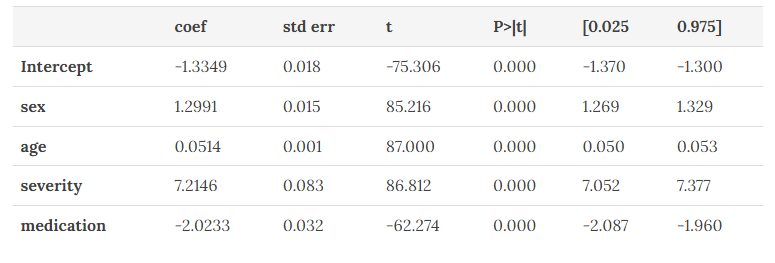

Ops… Aparentemente não. Nosso modelo de regressão está estimando um efeito causal de -2.0233 em vez de -1, ou seja, ele está superestimando o efeito causal. Isso acontece porque nosso modelo não está capturando todas as relações não lineares no nosso processo gerador de dados. Se nós fizéssemos um modelo que corresponde com o PGD isso provavelmente não aconteceria e conseguiríamos estimar o impacto causal corretamente. Só que, na vida real, nós raramente conhecemos o PGD.

Por sinal, não linearidade complexas é um dos grandes motivos para usarmos modelos de aprendizado de máquina.

# Aprendizado De Máquina
Se não linearidades são o problema, vamos usar um modelo de aprendizado de máquina, certo? Bom, vamos ver…

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
np.random.seed(42)

In [15]:
X = df_obs.drop("recovery", axis=1)
y = df_obs["recovery"]

model = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1)

print(cross_val_score(model, X, y, cv=5))

[0.9709928  0.96984636 0.9733455  0.96893817 0.96942233]


Acima, nós treinamos um modelo de floresta aleatória, com 100 árvores e profundidade máxima de 5. Nossa performance num set de validação é de aproximadamente 0,98, o que é um bom indicativo que nosso modelo está bem ajustado.

Para estimar o efeito causal nós precisaremos ser um pouco espertos. Como estamos lidando com um modelo de aprendizado de máquina, o efeito não precisa ser linear nem constante. Também não é possível simplesmente “ler” o modelo para ver como ele está entendendo o funcionamento do grau de medicamento.

O que vamos fazer então é gerar artificialmente alguns níveis de medicamento, de 0 a 4 em intervalos de 0.1mg. Depois, para cada nível, vamos ver a previsão média do modelo na base toda. Por fim, vamos plotar a previsão média contra o nível de medicamento

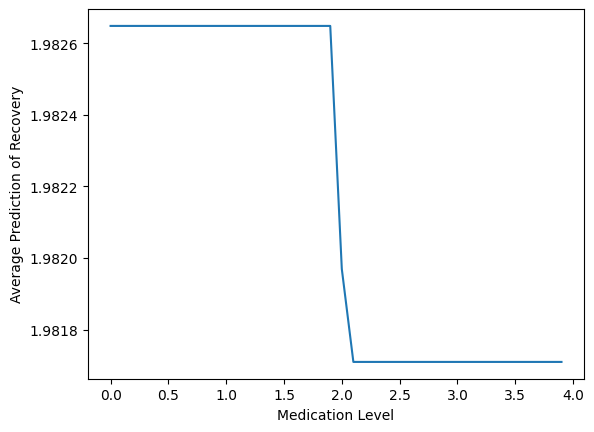

In [16]:
np.random.seed(42)
model.fit(X, y)
med_level = np.arange(0, 4, 0.1)
y_hats = [model.predict(X.assign(medication = med)).mean() for med in med_level]

plt.plot(med_level, y_hats)
plt.xlabel("Medication Level")
plt.ylabel("Average Prediction of Recovery")
plt.show()

E mais uma vez, parece que nossa ideia não deu certo. O modelo está prevendo que o medicamento diminui o tempo de recuperação, muito pouco. A queda prevista no tempo de recuperação é apenas de 1,99 dias para 1,96 dias e só acontece após o paciente receber 2mg de medicamento.

# Double/Debiased Machine Learning
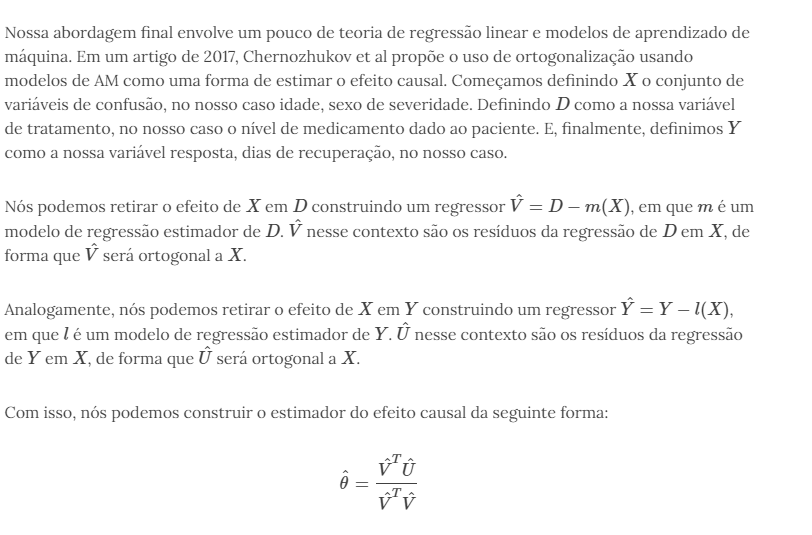

Vamos tentar…

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

X = df_obs.drop(columns=["recovery", "medication"]).values
Y = df_obs["recovery"].values
D = df_obs["medication"].values

np.random.seed(42)
Lhat = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1).fit(X, Y).predict(X)
Mhat = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1).fit(X, D).predict(X)

theta = np.dot((D - Mhat), (Y - Lhat)) / np.dot(D - Mhat, D - Mhat)

print("Causal Effect:", theta)

Causal Effect: -0.960112878822859


**Agora sim! O efeito estimado do medicamento é de -0.96. Isso é bem próximo do efeito real, que era -1. Mas por que isso funciona? Bom, para isso precisamos ir um pouco mais fundo em teoria econométrica.**

# Por Que Funciona?

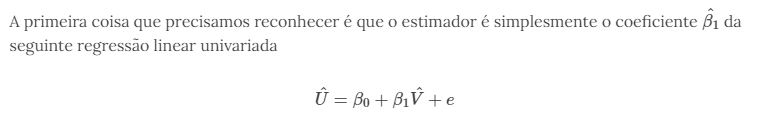

Se você não acredita em mim, pode verificar isso rodando essa regressão no Python e vendo que o coeficiente é exatamente o mesmo que estimamos acima.

In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit((D - Mhat).reshape(-1,1), Y - Lhat)

print(model.coef_)

[-0.96011223]


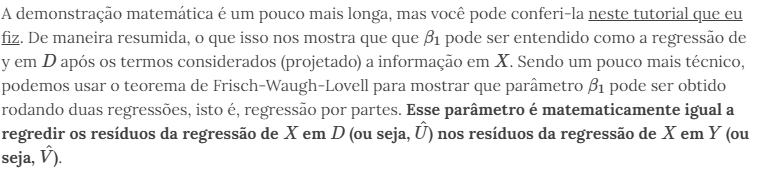

https://matheusfacure.github.io/2017/02/16/ols-mechanics/#fwl

Particionando os Dados
Podemos ainda ter uma última melhora em cima do estimador acima particionando os dados. Isso envolve separar os dados em treino e teste, treinar os modelos de aprendizado de máquina no dataset de treino, mas computar os resíduos usando o dataset de teste.

No código abaixo, nos fazemos esse particionamento no estilo k-fold, onde criamos 10 datasets de treino e 10 datasets de teste e realizamos 10 iterações de treino, teste e estimação do parâmetro 
θ
. Por fim, tiramos a média de todos os parâmetros estimados para obter uma estimativa final.

In [19]:
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)

thetas = []

np.random.seed(42)
for train, test in kf.split(X):
    
    Ghat = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1).fit(X[train],Y[train]).predict(X[test])
    Mhat = RandomForestRegressor(max_depth=5, n_estimators=100, n_jobs=-1).fit(X[train],D[train]).predict(X[test])
    
    Vhat = D[test] - Mhat
    Uhat = Y[test] - Ghat
    
    thetas += [np.mean(np.dot(Vhat,Uhat))/np.mean(np.dot(Vhat,Vhat))]


print("Causal Effect:", np.mean(thetas))    

Causal Effect: -0.977882592667485


(array([2., 0., 1., 0., 4., 0., 2., 1.]),
 array([-1.03746207, -1.02350613, -1.00955018, -0.99559424, -0.98163829,
        -0.96768234, -0.9537264 , -0.93977045, -0.92581451]),
 <BarContainer object of 8 artists>)

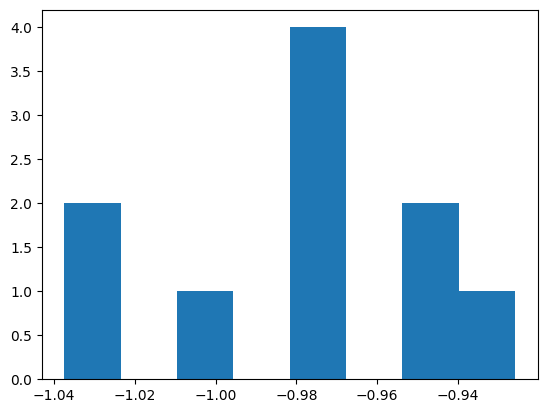

In [20]:
plt.hist(thetas, bins=8)

O efeito causal estimado é ainda mais próximo do efeito causal real de -1. Isso funciona pois previne problemas de sobre-ajustamento de modelos. Voltando a fórmula do estimador, é intuitivo ver porque isso seria um problema.

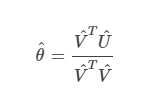

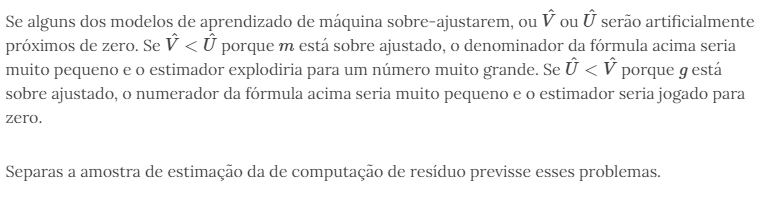

# Referências

Este post implementa o modelo descrito em [Double/Debiased Machine Learning for Treatment and Causal Parameters](https://arxiv.org/abs/1608.00060), de Chernozhukov et al, 2016. Uma boa referência para quem quiser aprender mais sobre esse modelo é a [palestra dada por Victor Chernozhukov](https://www.youtube.com/watch?v=eHOjmyoPCFU).